In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from matplotlib import pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

raw = pd.read_csv('train.csv')

## 1) Data preperation

In [5]:
# Fehlende Werte werden durch Durchschnittswerte ersetzt
lead = raw.loc[:,:'Datum']
tail = raw.loc[:,'Temperatur':]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(tail)
SimpleImputer()
tail = pd.DataFrame(imp.transform(tail), columns = tail.columns)
tail = tail.iloc[:14241,:]
raw = pd.concat([lead, tail],axis=1)
raw.drop(['index'], inplace=True, axis=1)
raw

,Datum,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit
0,2017-01-25 17:51:00,23.18,27.2720,721.25,0.004793,1.0
1,2017-01-25 17:51:59,23.15,27.2675,714.00,0.004783,1.0
2,2017-01-25 17:53:00,23.15,27.2450,713.50,0.004779,1.0
3,2017-01-25 17:54:00,23.15,27.2000,708.25,0.004772,1.0
4,2017-01-25 17:55:00,23.10,27.2000,704.50,0.004757,1.0
...,...,...,...,...,...,...
14236,2017-02-03 23:55:59,20.10,33.5900,505.00,0.004890,0.0
14237,2017-02-03 23:57:00,20.00,33.5000,504.50,0.004847,0.0
14238,2017-02-03 23:57:59,20.00,33.5000,500.50,0.004847,0.0
14239,2017-02-03 23:58:59,20.00,33.5000,502.00,0.004847,0.0


In [9]:
# Änderung des Datumstyps
raw['Datum'] = raw.Datum.astype('datetime64[ns]')
# Datum wird in einzelne nummerische Spalten aufgesplittet
raw['Jahr'] = raw['Datum'].dt.year
raw['Monat'] = raw['Datum'].dt.month
raw['Tag'] = raw['Datum'].dt.day
raw['Stunde'] = raw['Datum'].dt.hour
raw['Minute'] = raw['Datum'].dt.minute
raw['Sekunde'] = raw['Datum'].dt.second
raw['Wochentag'] = raw['Datum'].dt.strftime("%A")
# Ursprüngliche Datumsspalte wird verworfen --> wird nicht mehr benötigt
raw.drop(['Datum'], inplace=True, axis=1)
# One Hot Encoding, um kein Object type in den Daten zu haben
Wochentag = pd.get_dummies(raw[['Wochentag']], columns=['Wochentag'])
raw = pd.concat([raw, Wochentag], axis=1) 
raw.drop(['Wochentag'], inplace=True, axis=1)
# Ende der Datenvorverarbeitung:
df = raw.copy()
df.head()

,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit,Jahr,Monat,Tag,Stunde,Minute,Sekunde,Wochentag_Friday,Wochentag_Monday,Wochentag_Saturday,Wochentag_Sunday,Wochentag_Thursday,Wochentag_Tuesday,Wochentag_Wednesday
0,23.18,27.2720,721.25,0.004793,1.0,2017,1,25,17,51,0,0,0,0,0,0,0,1
1,23.15,27.2675,714.00,0.004783,1.0,2017,1,25,17,51,59,0,0,0,0,0,0,1
2,23.15,27.2450,713.50,0.004779,1.0,2017,1,25,17,53,0,0,0,0,0,0,0,1
3,23.15,27.2000,708.25,0.004772,1.0,2017,1,25,17,54,0,0,0,0,0,0,0,1
4,23.10,27.2000,704.50,0.004757,1.0,2017,1,25,17,55,0,0,0,0,0,0,0,1


## 2) Logistic Regression

In [10]:
# Features X und Label y werden definiert
X = df.drop("Anwesenheit",axis=1).values
y = df["Anwesenheit"].values
# Aufsplitten der Trainingsdaten in Trainings- (80%) und Validierungsdaten (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# Überprüfen des Vorgehens, indem die Shape der DataFrames angeschaut wird:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11392, 17), (2849, 17), (11392,), (2849,))

In [12]:
from sklearn.model_selection import GridSearchCV 

# Anlegen von Parametern für Hyperparametersuche (Penalty und Solver (=verschiedene Algorithmen) )
logreg = LogisticRegressionCV(cv=5, random_state=42, max_iter=20000)
param_grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'], #Default ist l2
             'solver' :['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] #Default ist lbfgs
             }
scores = ['accuracy', 'precision', 'recall']
# Einsetzen der zu untersuchenden Parametern, eigentliche Hyperparametersuche:
gs = GridSearchCV(logreg,
                 param_grid = param_grid,
                 scoring = scores,
                 refit="recall", # benötigt für die Suche mit mehreren Parametern -> wir entscheiden uns für den Recall, weil wir die Gelegenheiten minimieren müssen, bei denen Gegenwart = 1 Vorhersage = 0
                 return_train_score=True) # erhält Train Scores in cv_results_
gs.fit(X_train,y_train)

C:\Users\Student\anaconda3\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Student\anaconda3\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Student\anaconda3\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Student\anaconda3\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Student\anaconda3\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line s

GridSearchCV(estimator=LogisticRegressionCV(cv=5, max_iter=20000,
                                            random_state=42),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             refit='recall', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall'])

In [14]:
# Optimales Modell:
print(f"Ergebnis der CV: \nBestes Modell ist {gs.best_estimator_} \nmit Hyperparametern {gs.best_params_} und einem Recall von {gs.best_score_}")

Ergebnis der CV: 
Bestes Modell ist LogisticRegressionCV(cv=5, max_iter=20000, random_state=42, solver='newton-cg') 
mit Hyperparametern {'penalty': 'l2', 'solver': 'newton-cg'} und einem Recall von 0.7561643835616437


In [15]:
# Übernahme der gefundenen optimalen Parametern in Logistisches Regressions Modell
logreg = LogisticRegressionCV(cv=5, random_state=42, max_iter=20000, penalty='l2', solver='newton-cg').fit(X_train, y_train) # Kreuzvalidierung mit 5 folds
# Vorausgesagtes Label anhand der Features 
y_pred = logreg.predict(X_test)
# Wahrscheinlichkeit des Labels
y_proba = logreg.predict_log_proba(X_test)

logreg.score(X_test, y_test)

C:\Users\Student\anaconda3\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Student\anaconda3\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Student\anaconda3\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Student\anaconda3\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Student\anaconda3\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line s

0.8975078975078975

In [17]:
# Erstellen der Kreuztabelle und zuordnen der Werte TP, FP, FN, TN
kreuztabelle = pd.crosstab(index=y_pred, columns=y_test, rownames=["predicted"], colnames=["actual"])
TP = kreuztabelle.values[1,1] # True Positives
FP = kreuztabelle.values[1,0] # False Positives
FN = kreuztabelle.values[0,1] # False Negatives
TN = kreuztabelle.values[0,0] # True Negatives
# Veranschaulichung:
kreuztabelle.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=False)

actual,1.0,0.0
predicted,,
1.0,557,116
0.0,176,2000


In [18]:
# Definition der einzelnen Funktionen zur Berechnung der untenstehenden Werte
precision = TP/(TP+FP)
TPR = TP/(TP+FN) # Recall
accuracy = (TP+TN)/(TP+TN+FN+TN)
F1 = 2*(precision*TPR/(precision+TPR))
FPR = FP/(FP+TN)

# Precision: Welcher Anteil der als 1 klassifizierten Daten ist auch mit 1 gelabelt?
print(f"Precision: {precision}")
# Accuracy: Anteil der korrekten (0 oder 1 Vorhersagen) an allen Vorhersagen
print(f"Accuracy Score: {accuracy}")
# F1:was macht ein gutes Modell aus? Sowohl eine hohe Trefferquote haben als auch präzise
print(f"F1: {F1}")
# Recall: Welchen Anteil der mit 1 gelabelten Daten findet der Klassifikator?
print(f"Recall (TPR): {TPR}")
# False-Positive-Rate:Anteil der negativen Fälle, die in den Daten fälschlicherweise als positive Fälle identifiziert wurden
print(f"FPR: {FPR}")

Precision: 0.8276374442793462
Accuracy Score: 0.5402493133319248
F1: 0.7923186344238975
Recall (TPR): 0.7598908594815825
FPR: 0.054820415879017016


In [19]:
# Wahrscheinlichkeitsvorhersage des Modells für die Testdaten erhalten
probs = logreg.predict_proba(X_test)
preds = []
# Klassifizierung (0/1) für 100 thresholds von 0 bis 1 generieren:
for threshold in np.arange(0,1.01,0.01):
    preds.append(probs > threshold)

In [21]:
# Generiertes DataFrame 'calc' das alle Vorhersagen enthält
calc = pd.DataFrame(index=np.arange(0,2849,1)) # leeres DataFrame mit shape der Test Daten
for ind, el in enumerate(preds):
    calc[ind] = pd.DataFrame(el).drop(0, axis =1).astype(int) # Neue Spalte für die Thresholds 0-100, enthält jeweils die Fallvorhersage für den angegebenen Schwellenwert als int (0/1)
calc['Anwesenheit'] = y_test.astype(int) # Anhängen der letzten Spalte mit dem true Label der Testdaten

C:\Users\Student\AppData\Local\Temp/ipykernel_22044/623356236.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  calc[ind] = pd.DataFrame(el).drop(0, axis =1).astype(int) # Generate a new Column for Thresholds 0-100, each holding the case prediction for the given threshold as int (0/1)
C:\Users\Student\AppData\Local\Temp/ipykernel_22044/623356236.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  calc['Anwesenheit'] = y_test.astype(int) # Append last Column holding true Label of Test Data


In [22]:
l = []
for el in np.arange(0,101,1): # für jeden threshold-index:
    tn, fp, fn, tp = confusion_matrix(calc['Anwesenheit'], calc[el]).ravel() # return TN,FP,FN,TP scores
    tpr = tp / (tp+fn) # TPR berechnen
    fpr = fp / (fp+tn) # FPR berechnen
    l.append(np.array([tpr,fpr])) # beides in die Liste l schreiben
rates_ = pd.DataFrame(l, columns = ['TPR','FPR']) #  DataFrame generieren mit Spalten = FPR, TPR, Zeilen = Threshold
rates_['Threshold'] = np.arange(0,1.01,0.01) # Column für Threshold anhängen
rates_[['Threshold','TPR','FPR']].to_csv('ROC_LR.csv', index=False) # Speichern als csv

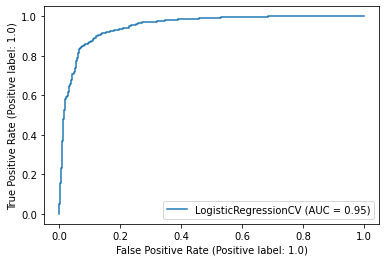

In [23]:
from sklearn.metrics import RocCurveDisplay
# Darstellung der ROC Kurve um das Modell mit anderen Modellen vergleichen zu können
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.show()

## 3) Anwendung auf Testdaten

In [25]:
# Fehlende Werte werden durch Durchschnittswerte ersetzt
test = pd.read_csv('test.csv')
lead = test.loc[:,:'Datum']
tail = test.loc[:,'Temperatur':]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(tail)
SimpleImputer()
tail = pd.DataFrame(imp.transform(tail), columns = tail.columns)
tail = tail.iloc[:14241,:]
test = pd.concat([lead, tail],axis=1)
test.drop(['index'], inplace=True, axis=1)

# Änderung des Datumstyps
test['Datum'] = test.Datum.astype('datetime64[ns]')
# Datum wird in einzelne nummerische Spalten aufgesplittet
test['Jahr'] = test['Datum'].dt.year
test['Monat'] = test['Datum'].dt.month
test['Tag'] = test['Datum'].dt.day
test['Stunde'] = test['Datum'].dt.hour
test['Minute'] = test['Datum'].dt.minute
test['Sekunde'] = test['Datum'].dt.second
test['Wochentag'] = test['Datum'].dt.strftime("%A")
# Ursprüngliche Datumsspalte wird nicht mehr gebraucht und daher verworfen
test.drop(['Datum'], inplace=True, axis=1)
# One Hot Encoding, um kein Object type in den Daten zu haben
Wochentag = pd.get_dummies(test[['Wochentag']], columns=['Wochentag'])
test = pd.concat([test, Wochentag], axis=1) 
test.drop(['Wochentag'], inplace=True, axis=1)
# Einfügen der fehlenden Wochentage um gleiche Featureanzahl wie bei den Testdaten zu erhalten
test['Wochentag_Thursday'] = 0
test['Wochentag_Friday'] = 0
# Überprüfen, ob alle erforderlichen Features dabei sind
test.columns

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Wassergehalt', 'Jahr',
       'Monat', 'Tag', 'Stunde', 'Minute', 'Sekunde', 'Wochentag_Monday',
       'Wochentag_Saturday', 'Wochentag_Sunday', 'Wochentag_Tuesday',
       'Wochentag_Wednesday', 'Wochentag_Thursday', 'Wochentag_Friday'],
      dtype='object')

In [27]:
# Vorhersage wird in Spalte geschrieben:
test['Vorhersage'] = logreg.predict(test)
test.head()

C:\Users\Student\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Jahr,Monat,Tag,Stunde,Minute,Sekunde,Wochentag_Monday,Wochentag_Saturday,Wochentag_Sunday,Wochentag_Tuesday,Wochentag_Wednesday,Wochentag_Thursday,Wochentag_Friday,Vorhersage
0,20.050000,33.545000,507.000000,0.004869,2017,2,4,0,1,0,0,1,0,0,0,0,0,0.0
1,20.033333,33.626667,505.333333,0.004875,2017,2,4,0,2,0,0,1,0,0,0,0,0,0.0
2,20.000000,33.590000,505.500000,0.004860,2017,2,4,0,3,0,0,1,0,0,0,0,0,0.0
3,20.000000,33.645000,504.500000,0.004868,2017,2,4,0,4,0,0,1,0,0,0,0,0,0.0
4,20.000000,33.626667,504.666667,0.004865,2017,2,4,0,4,59,0,1,0,0,0,0,0,0.0
